# modeling.ipynb - Arrest Prediction 

**Goal:** Predict whether an incident results in an arrest (arrest 0/1).

**Input:** data/processed/model_input.csv (from feature_engineering.ipynb).
Output: Trained model + evaluation report + saved artifacts in models/.

In [1]:
# Core
import os, json, joblib, numpy as np, pandas as pd 
from pathlib import Path 

# Modeling 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Plots
import matplotlib.pyplot as plt

# Paths 
REPO = Path.cwd()
while REPO.name != "chicago-crime-pipeline" and REPO.parent != REPO:
    REPO = REPO.parent
DATA = REPO / "data" / "processed"
MODELS_DIR = REPO / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA

PosixPath('/Volumes/easystore/Projects/chicago-crime-pipeline/data/processed')

In [2]:
# Load the data 
df = pd.read_csv(DATA / "arrest_features.csv")
print(df.shape)
df.head()

# Sanity checks 
assert "arrest" in df.columns, "Target column 'arrest' missing"
print(df['arrest'].value_counts(dropna=False))
print(df.isna().mean().sort_values(ascending=False).head(10))

(10482, 10)
arrest
0    8972
1    1510
Name: count, dtype: int64
id                      0.0
date                    0.0
primary_type            0.0
location_description    0.0
arrest                  0.0
location_grouped        0.0
year                    0.0
month                   0.0
dow                     0.0
hour                    0.0
dtype: float64


In [3]:
# Split train/test

TARGET = 'arrest'

y = df[TARGET].astype(int).values
X = df.drop(columns=[TARGET]).copy()

# Identify feature types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number', 'bool']).columns.to_list()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

Categorical: ['date', 'primary_type', 'location_description', 'location_grouped']
Numeric: ['id', 'year', 'month', 'dow', 'hour']


((8385, 9), (2097, 9))

In [4]:
# Preprocessor (OneHot for categoricals, passthrough numeric)
pre = ColumnTransformer(
    transformers = [
("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
("num", "passthrough", num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

## Baseline Model: Logistic Regression 

In [5]:
logit = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=1000, class_weight="balanced", n_jobs=None, solver="lbfgs"
    ))
])

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR-AUC):", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

ROC-AUC: 0.6420040952609346
Average Precision (PR-AUC): 0.26866766623680294
              precision    recall  f1-score   support

           0      0.860     0.997     0.923      1795
           1      0.647     0.036     0.069       302

    accuracy                          0.858      2097
   macro avg      0.754     0.517     0.496      2097
weighted avg      0.829     0.858     0.800      2097



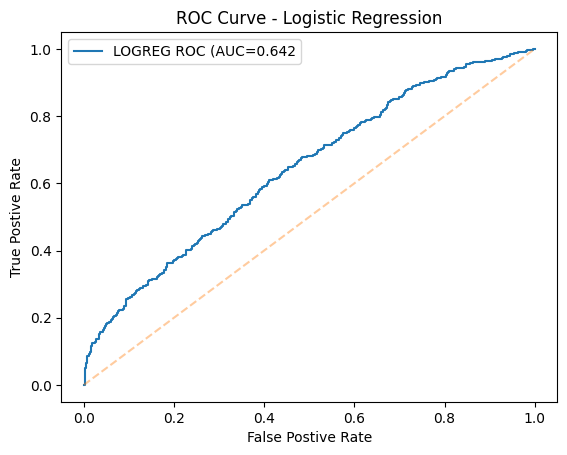

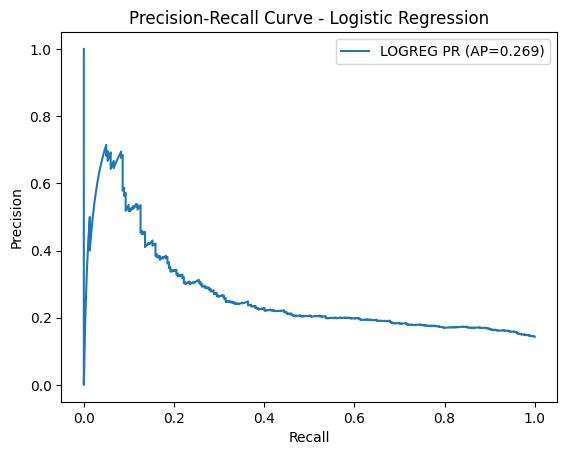

In [6]:
 # Plot ROC and PR curves for Logistic Regression 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.Figure()
plt.plot(fpr, tpr, label=f"LOGREG ROC (AUC={auc(fpr, tpr):.3f}")
plt.plot([0,1],[0,1], "--", alpha=0.4)
plt.xlabel("False Postive Rate"); plt.ylabel("True Postive Rate")
plt.title("ROC Curve - Logistic Regression"); plt.legend(); plt.show()

plt.figure()
ap = average_precision_score(y_test, y_proba)
plt.plot(rec, prec, label=f"LOGREG PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression"); plt.legend(); plt.show()

## Baseline Model: Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = Pipeline(steps=[
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight="balanced", random_state=42, n_jobs=1
    ))
]) 

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

print("RF ROC-AUC:", roc_auc_score(y_test, rf_proba))
print("RF PR-AUC:",  average_precision_score(y_test, rf_proba))
print(classification_report(y_test, rf_pred, digits=3))

RF ROC-AUC: 0.8651413971849695
RF PR-AUC: 0.6265055867308916
              precision    recall  f1-score   support

           0      0.903     0.985     0.942      1795
           1      0.804     0.368     0.505       302

    accuracy                          0.896      2097
   macro avg      0.853     0.676     0.723      2097
weighted avg      0.888     0.896     0.879      2097



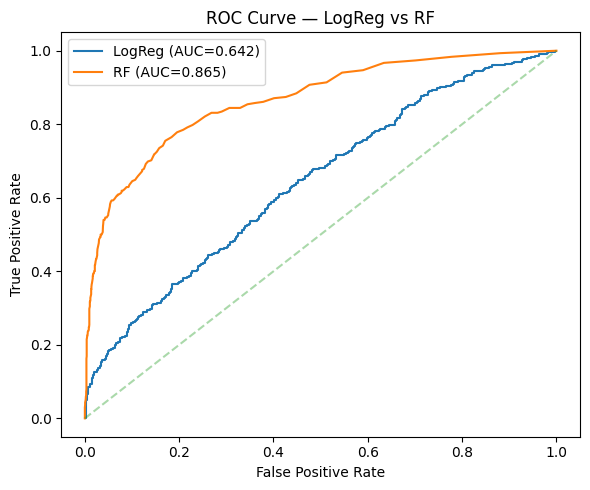

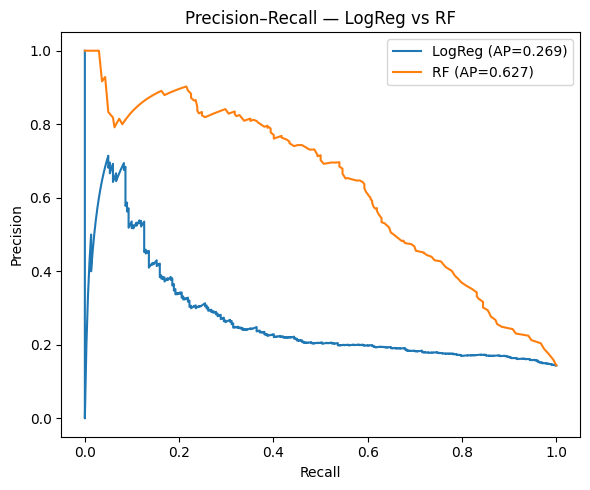

In [9]:
# Side by side ROC & PR curves (LogReg vs RF)

# LOGREF curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba)
prec_log, rec_log, _ = precision_recall_curve(y_test, y_proba)
auc_log = auc(fpr_log, tpr_log)
ap_log  = average_precision_score(y_test, y_proba)

# RF curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)
ap_rf  = average_precision_score(y_test, rf_proba)

# ROC
plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC={auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"RF (AUC={auc_rf:.3f})")
plt.plot([0,1],[0,1], "--", alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — LogReg vs RF"); plt.legend(); plt.tight_layout(); plt.show()

# PR
plt.figure(figsize=(6,5))
plt.plot(rec_log, prec_log, label=f"LogReg (AP={ap_log:.3f})")
plt.plot(rec_rf,  prec_rf,  label=f"RF (AP={ap_rf:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — LogReg vs RF"); plt.legend(); plt.tight_layout(); plt.show()

## 5-fold Cross-Validation (ROC-AUC & PR-AUC)

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(pipe, X, y, name):
    scores = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},
        n_jobs=-1
    )
    return pd.DataFrame({
        "model": [name],
        "roc_auc_mean": [scores["test_roc_auc"].mean()],
        "roc_auc_std":  [scores["test_roc_auc"].std()],
        "pr_auc_mean":  [scores["test_pr_auc"].mean()],
        "pr_auc_std":   [scores["test_pr_auc"].std()],
    })

cv_log = cv_scores(logit, X, y, "LogReg")
cv_rf  = cv_scores(rf,    X, y, "RandomForest")

cv_table = pd.concat([cv_log, cv_rf], ignore_index=True)
cv_table

,model,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,LogReg,0.651575,0.034681,0.285602,0.034033
1,RandomForest,0.851889,0.010986,0.617065,0.020952


## Tune Random Forest

In [12]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import tempfile

# --- QUICK MODE knobs ---
QUICK = True
N_ITER  = 8 if QUICK else 25      # fewer combos
FOLDS   = 2 if QUICK else 5       # fewer CV folds
SUB_N   = 5000 if QUICK else None # subsample rows for tuning (None=all)

# Optional: subsample training set
if SUB_N is not None and len(X_train) > SUB_N:
    X_tr_small, _, y_tr_small, _ = train_test_split(
        X_train, y_train, train_size=SUB_N, stratify=y_train, random_state=42
    )
else:
    X_tr_small, y_tr_small = X_train, y_train

# Cache preprocessing so it doesn’t re-fit every fold
cache_dir = tempfile.mkdtemp()

rf_pipe = Pipeline(steps=[
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_jobs=1,               # single-threaded inside RF
        class_weight="balanced",
        random_state=42,
        bootstrap=True,
        max_samples=0.7         # subsample rows per tree
    ))
], memory=cache_dir)

# Tighter, faster search space
param_distributions = {
    "clf__n_estimators": randint(80, 200),
    "clf__max_depth": randint(6, 14),
    "clf__min_samples_split": randint(2, 12),
    "clf__min_samples_leaf": randint(2, 12),
    "clf__max_features": uniform(0.3, 0.4),
}

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring="average_precision",   # single metric = faster
    refit=True,
    cv=cv,
    n_jobs=-1,                     # parallelize across folds/params
    verbose=1,
    random_state=42
)

rf_search.fit(X_tr_small, y_tr_small)
print("Best params (quick):", rf_search.best_params_)
print("CV best PR-AUC (quick):", rf_search.best_score_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best params (quick): {'clf__max_depth': 12, 'clf__max_features': np.float64(0.6186171947440932), 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 6, 'clf__n_estimators': 182}
CV best PR-AUC (quick): 0.5717300500471179


In [13]:
# Refit best RandomForest on FULL training data, evaluate on test, tune threshold, save artifacts
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_curve
)
import numpy as np, os, time, json, joblib

# 1) Build fresh pipeline and apply best params from the scout search
best = rf_search.best_params_  # uses keys like "clf__max_depth", etc.

final_pipe = Pipeline(steps=[
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_jobs=-1,                 # parallel OK for a single final fit
        class_weight="balanced",
        random_state=42,
        bootstrap=True,
        max_samples=None           # use all rows per tree
    ))
])

In [14]:
final_pipe.set_params(**best)

# 2) Train on full training set
final_pipe.fit(X_train, y_train)

# 3) Evaluate on held-out test set (default 0.5 threshold)
proba = final_pipe.predict_proba(X_test)[:, 1]
pred05 = (proba >= 0.5).astype(int)

print("=== TEST metrics @ threshold=0.5 ===")
print("PR-AUC:",  round(average_precision_score(y_test, proba), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print(classification_report(y_test, pred05, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred05))

# 4) Tune threshold by maximizing F1 on the PR curve (simple, fast)
prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5  # guard if curve edge case
pred_tuned = (proba >= best_thr).astype(int)

=== TEST metrics @ threshold=0.5 ===
PR-AUC: 0.6231
ROC-AUC: 0.8696
              precision    recall  f1-score   support

           0      0.938     0.896     0.917      1795
           1      0.512     0.646     0.571       302

    accuracy                          0.860      2097
   macro avg      0.725     0.771     0.744      2097
weighted avg      0.876     0.860     0.867      2097

Confusion matrix:
 [[1609  186]
 [ 107  195]]


In [15]:
print("\n=== Threshold tuning (F1) ===")
print("Best threshold:", float(best_thr))
print("Best F1:", float(f1s[best_idx]))
print(classification_report(y_test, pred_tuned, digits=3))
print("Confusion matrix (tuned):\n", confusion_matrix(y_test, pred_tuned))

# 5) (Optional) Compare to scout CV score to sanity-check overfitting
try:
    print("\nScout CV PR-AUC (subsample):", round(rf_search.best_score_, 4))
except Exception:
    pass

# 6) Save model + params (good hygiene)
os.makedirs("artifacts", exist_ok=True)
stamp = time.strftime("%Y%m%d-%H%M%S")
joblib.dump(final_pipe, f"artifacts/rf_pipe_{stamp}.joblib")
with open(f"artifacts/rf_best_params_{stamp}.json", "w") as f:
    json.dump({k: (float(v) if hasattr(v, "item") else v) for k, v in best.items()}, f, indent=2)

print(f"\nSaved: artifacts/rf_pipe_{stamp}.joblib and rf_best_params_{stamp}.json")


=== Threshold tuning (F1) ===
Best threshold: 0.5335699555269775
Best F1: 0.5955414012733861
              precision    recall  f1-score   support

           0      0.935     0.923     0.929      1795
           1      0.574     0.619     0.596       302

    accuracy                          0.879      2097
   macro avg      0.754     0.771     0.762      2097
weighted avg      0.883     0.879     0.881      2097

Confusion matrix (tuned):
 [[1656  139]
 [ 115  187]]

Scout CV PR-AUC (subsample): 0.5717

Saved: artifacts/rf_pipe_20250921-193338.joblib and rf_best_params_20250921-193338.json
